In [13]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import os
import sys
sys.path.append("..")
from vos import VOS

# Load data, set up problem

In [14]:
dataset = MNIST(root = "~/datasets/MNIST", train = True)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

samples = dataset.data
targets = dataset.targets
data = TensorDataset(transform(samples).unsqueeze(1), targets)

loader = DataLoader(data, batch_size = 1024)

In [15]:
data_dict = {key:[] for key in dataset.targets.unique().tolist()}
for batch in loader:
    x, y = batch
    for pair in zip(x, y):
        x, y = pair
        data_dict[y.item()].append(x)

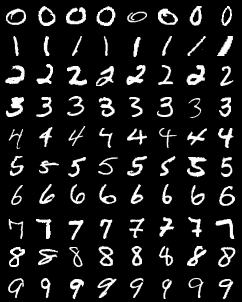

In [16]:
images = [random.sample(data_dict[key], 8) for key in np.sort(list(data_dict.keys()))]
images = torch.stack(list(itertools.chain.from_iterable(images)))
grid = make_grid(images, nrow = 8, normalize = True)

img = ToPILImage()(grid)
img

In [17]:
backbone = resnet18()
backbone.conv1 = nn.Conv2d(1, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
backbone.fc = nn.Linear(512, 10)
for module in backbone.modules():
    if type(module) == nn.BatchNorm2d:
        module.track_running_stats = False

In [18]:
class OODDetector(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = nn.Sequential(nn.Linear(1, latent_dim),
                                 nn.ReLU(),
                                 nn.Linear(latent_dim, 1))
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
ood_detector = OODDetector(latent_dim = 512)

# Optional model pretraining

In [19]:
pretrain = False
if pretrain:
    criterion = nn.CrossEntropyLoss()
    opt = Adam(backbone.parameters(), lr = 1e-3)
    lr_scheduler = ReduceLROnPlateau(opt, factor = 0.5)
    print(f"CUDA is {torch.cuda.is_available()}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    backbone.to(device)

    epochs = 100
    for epoch in range(epochs):
        running_loss = 0.
        iteration_counter = 0
        for batch in loader:
            samples, targets = batch
            samples, targets = samples.to(device), targets.to(device)

            opt.zero_grad()

            outputs = backbone(samples)

            loss = criterion(outputs, F.one_hot(targets).float())
            loss.backward()

            opt.step()

            running_loss += loss
            iteration_counter += 1
        
        if epoch % 10 == 9:
            print(f"Epoch: {epoch + 1}")
            print(f"Loss: {running_loss/iteration_counter}")

    backbone.to("cpu")
    torch.save(backbone, "../model_weights/pretrained_model.pt")
else:
    backbone = torch.load("../model_weights/pretrained_model.pt", weights_only = False)

# Set up VOS

In [20]:
vos = VOS(backbone, ood_detector, data, queue_size = 1024)

# Data visualizations

In [21]:
target = 0
mode = vos.class_conditional_modes[target]

latents = vos.stripped_backbone(torch.stack(vos.queue[target])).squeeze().detach()
id_likelihoods = vos.compute_gmm_log_likelihood(latents, target)

In [22]:
vos.sample_ood()
ood_likelihoods = vos.compute_gmm_log_likelihood(vos.ood_queue[target], target)

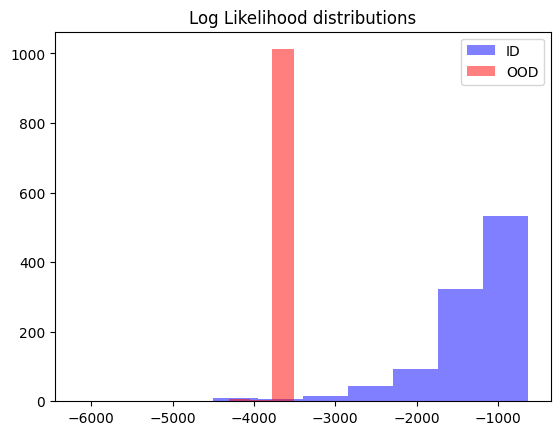

In [23]:
plt.hist(id_likelihoods, color = "blue", label = "ID", alpha = 0.5)
plt.hist(ood_likelihoods, color = "red", label = "OOD", alpha = 0.5)
plt.title("Log Likelihood distributions")
plt.legend()
plt.show()

# Train VOS

In [24]:
vos.train(iterations = 50, lr = 1e-3, beta = 0.1)

Iteration: 0
Classification Loss: 8.782517397776246e-07
Uncertainty Loss: 1.9869998693466187
Iteration: 1
Classification Loss: 4.762772732647136e-05
Uncertainty Loss: 1.5302205085754395
Iteration: 2
Classification Loss: 0.0023796544410288334
Uncertainty Loss: 1.516385555267334
Iteration: 3
Classification Loss: 4.269522469257936e-05
Uncertainty Loss: 1.4606256484985352
Iteration: 4
Classification Loss: 0.0012316855136305094
Uncertainty Loss: 1.381195068359375
Iteration: 5
Classification Loss: 0.0024949521757662296
Uncertainty Loss: 1.4088220596313477
Iteration: 6
Classification Loss: 0.0008036536164581776
Uncertainty Loss: 1.3515509366989136
Iteration: 7
Classification Loss: 0.0005855687195435166
Uncertainty Loss: 1.356630802154541
Iteration: 8
Classification Loss: 0.00036478167749010026
Uncertainty Loss: 1.3219691514968872
Iteration: 9
Classification Loss: 0.0006732533220201731
Uncertainty Loss: 1.3206268548965454
Iteration: 10
Classification Loss: 0.0005968783516436815
Uncertainty Los

# Save model

In [25]:
torch.save(vos.backbone, "../model_weights/vos_model.pt")

In [26]:
torch.save(vos.ood_detector, "../model_weights/vos_ood_detector.pt")

In [27]:
vos.uncertainty_loss()

tensor(0.0864, grad_fn=<AddBackward0>)

# Demonstrate some post-training metrics on synthesized data

In [28]:
id_loss, ood_loss = 0., 0.

id_samples = torch.Tensor([])
for key in vos.queue.keys():
    new_samples = torch.stack(vos.queue[key])
    id_samples = torch.cat((id_samples, new_samples))
id_samples = id_samples[torch.randperm(id_samples.shape[0])]

id_logits = vos.backbone(id_samples)

ood_latents = vos.ood_queue[key]
classifier = list(vos.backbone.children())[-1]
ood_logits = classifier(ood_latents)

id_energies, ood_energies = vos.free_energy(id_logits), vos.free_energy(ood_logits)
id_energy_surface, ood_energy_surface = vos.ood_detector(id_energies), vos.ood_detector(ood_energies)

# At the end of training, we want one group to be positive, one group to be negative

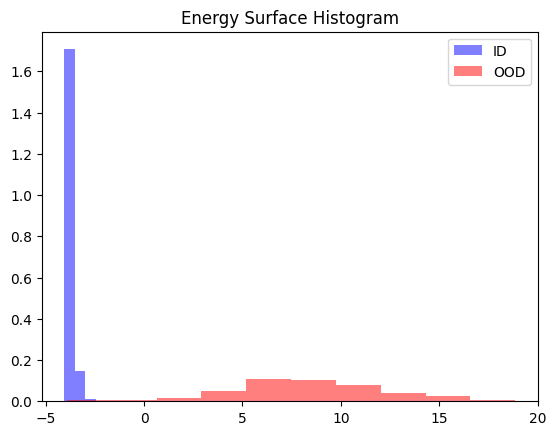

In [29]:
plt.hist(id_energy_surface.cpu().detach().flatten(), color = 'blue',
                                                     alpha = 0.5, 
                                                     label = "ID",
                                                     density = True)
plt.hist(ood_energy_surface.cpu().detach().flatten(), color = 'red', 
                                                     alpha = 0.5, 
                                                     label = "OOD", 
                                                     density = True)
plt.title("Energy Surface Histogram")
plt.legend()
plt.show()

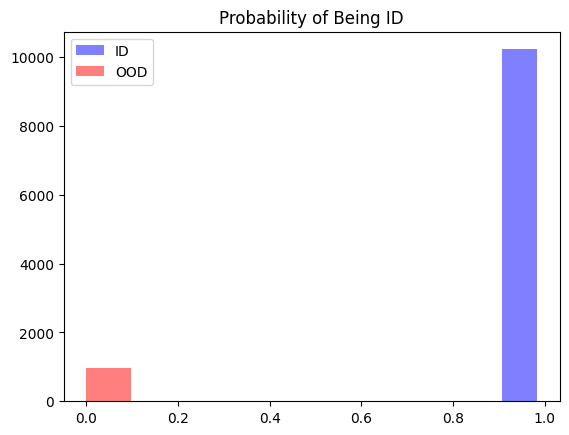

In [30]:
prob_id_is_id = torch.exp(-id_energy_surface)/(1 + torch.exp(-id_energy_surface))
prob_ood_is_id = torch.exp(-ood_energy_surface)/(1 + torch.exp(-ood_energy_surface))
prob_id_is_id = prob_id_is_id.detach().flatten()
prob_ood_is_id = prob_ood_is_id.detach().flatten()
plt.hist(prob_id_is_id, color = "blue", label = "ID", alpha = 0.5)
plt.hist(prob_ood_is_id, color = "red", label = "OOD", alpha = 0.5)
plt.title("Probability of Being ID")
plt.legend()
plt.show()